In [1]:
%matplotlib notebook

import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [117]:
from trajectories import simulate, simulate_rotation, get_view_vector, std_from_r, trajectory

In [69]:
from metric import rmse

In [207]:
angles = np.arange(360)
radius = 3

In [208]:
views = []
positions = []
for angle in angles:
    pos = simulate(angle, radius)
    rot = simulate_rotation(angle, radius)
    view = get_view_vector(rot, pos)
    views.append(view)
    positions.append(pos)
positions = np.array(positions)
views = np.array(views)

<IPython.core.display.Javascript object>


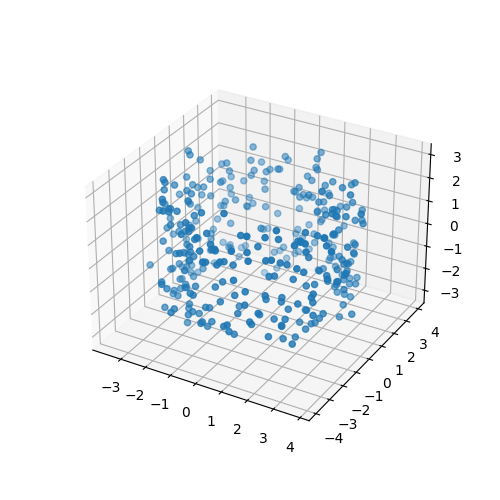

In [209]:
# views = np.array(views)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2])
# for item in views:
#     x, y, x = np.multiply()
#     item = np.array(item)
#     ax.plot(item[:, 0], item[:, 1], item[:, 2])

In [210]:
with open('/home/nrogovoy/Downloads/mt_trajectory.pkl', 'rb') as f:
    data = pickle.load(f)

In [221]:
import numpy as np
# from filterpy.kalman import KalmanFilter, UnscentedKalmanFilter, ExtendedKalmanFilter
from KalmanFilter import KalmanFilter
from filterpy.common import Q_discrete_white_noise

In [212]:
my_filter = KalmanFilter(dim_x=6, dim_z=3)

In [213]:
positions

array([[ 0.1336495 ,  3.51864199, -0.85516139],
       [ 0.15147758,  3.00317018,  0.75566221],
       [ 0.56783263,  3.26484327,  1.83699234],
       ...,
       [-0.91520748,  3.21316975,  1.45666504],
       [ 0.0748637 ,  3.4081694 ,  0.38988863],
       [ 0.13284832,  2.40659188, -1.20400535]])

In [214]:
dt = 1

In [215]:
my_filter.x = [positions[0][0], positions[0][1], positions[0][2], 0., 0., 0.]

# x, y, z, x', y', z',
my_filter.F = np.array([[1., 0, 0., dt, 0, 0],
                        [0., 1., 0, 0, dt, 0],
                        [0., 0., 1., 0., 0, dt],
                        [0., 0., 0., 1., 0., 0],
                        [0., 0., 0., 0., 1., 0],
                        [0., 0., 0, 0, 0, 1.]
                        ])    # state transition matrix

my_filter.H = np.array([
    [1., 0., 0., 0, 0, 0],
    [0., 1., 0., 0, 0, 0],
    [0., 0., 1., 0, 0, 0],
])    # Measurement function
# my_filter.P                  # covariance matrix
my_filter.R = std_from_r(0.001, radius)                      # state uncertainty
my_filter.Q = Q_discrete_white_noise(3, dt, 0.5, 2) # process uncertainty


In [216]:
filtered = []
for i in range(1, len(positions)):
    my_filter.predict()
    y = np.array(positions[i]).reshape((3, 1))
#     print(y.shape)
    my_filter.update(y)

    # do something with the output
    x = my_filter.x
    filtered.append(x)

<IPython.core.display.Javascript object>


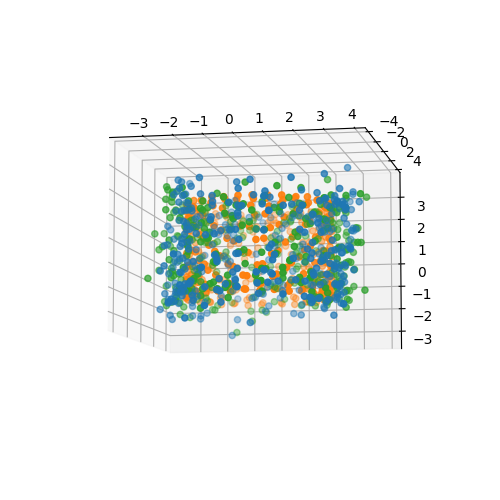

In [217]:
filtered = np.array(filtered)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(filtered[:, 0], filtered[:, 1], filtered[:, 2])
ax.scatter(orig[:, 0], orig[:, 1], orig[:, 2])
ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2])

In [218]:
orig = []
for i in range(1, 360):
    pos = trajectory(i, radius)
    orig.append(pos)
orig = np.array(orig)

In [219]:
rmse(orig, filtered[:, :3])

(array([0.2274736 , 0.42179934, 0.39645422]), 0.34857571763543466)

In [220]:
rmse(orig, positions[1:])

(array([0.33021137, 0.33107115, 0.30245688]), 0.3212464656947723)

In [222]:
kalman = KalmanFilter(1, 0, 0, 0, 0.1, 0.001, 0.001, 0.001)

In [225]:
filtered = []
for i in range(len(positions)):
    kalman.predict()
#     y = np.array(positions[i]).reshape((3, 1))
#     print(y.shape)
    x, y, z = positions[i]
    x_n, y_n, z_n = kalman.update([x, y, z])

#     do something with the output
#     x = my_filter.x
    filtered.append([x_n, y_n, z_n])
filtered = np.array(filtered)

In [234]:
rmse(orig, filtered[1:, 0, 0])

(array([0.41147663, 0.39324009, 0.34986063]), 0.38485911801990197)

In [236]:
positions.shape

(360, 3)

In [237]:
from scipy.interpolate import Akima1DInterpolator
timestamps = np.arange(360)
interpol_x = Akima1DInterpolator(timestamps, positions[:, 0])
interpol_y = Akima1DInterpolator(timestamps, positions[:, 1])
interpol_z = Akima1DInterpolator(timestamps, positions[:, 2])